# 🎵 Preprocesamiento y Augmentation de Datos de Voz

## Pipeline Completo de Preparación de Datos

Este notebook prepara los datos de audio para entrenamiento de modelos CNN:

### 📋 Pipeline:
1. **Carga de Audios**: Archivos .egg de Healthy y Parkinson
2. **Visualización**: Señales de audio y características
3. **Preprocesamiento**: Resampling, segmentación, Mel spectrograms
4. **Data Augmentation**: Pitch shift, time stretch, noise, SpecAugment
5. **Generación de Cache**: Guardar datos procesados para reutilizar

### 🎯 Output:
- Cache preprocesado en `cache/healthy/` y `cache/parkinson/`
- Visualizaciones de cada etapa del proceso
- Estadísticas de los datos generados

### ⏱️ Tiempo:
- Primera ejecución: ~7-10 minutos (genera cache)
- Re-ejecuciones: ~1 minuto (carga cache existente)

### 💡 Uso:
Una vez ejecutado este notebook, los notebooks de entrenamiento (`cnn_training.ipynb`, `cnn_da_training.ipynb`) cargarán los datos en segundos.


## 1. Setup y Configuración


In [1]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Agregar módulos propios al path
sys.path.insert(0, str(Path.cwd()))

# Importar módulos propios
from modules import preprocessing, augmentation, dataset, visualization
from modules.preprocessing import (
    SAMPLE_RATE, WINDOW_MS, OVERLAP, N_MELS, HOP_MS,
    FFT_WINDOW, TARGET_FRAMES,
    print_preprocessing_config
)
from modules.augmentation import (
    preprocess_audio_with_augmentation,
    create_augmented_dataset
)
from modules.dataset import (
    build_full_pipeline,
    to_pytorch_tensors,
    parse_filename
)
from modules.visualization import (
    visualize_audio_and_spectrograms,
    plot_spectrogram_comparison
)

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("="*70)
print("🎵 DATA PREPROCESSING & AUGMENTATION")
print("="*70)
print(f"✅ Librerías cargadas correctamente")
print(f"📦 Librosa: {librosa.__version__}")
print("="*70)

# Mostrar configuración de preprocesamiento
print("\n")
print_preprocessing_config()
print("="*70)


🎵 DATA PREPROCESSING & AUGMENTATION
✅ Librerías cargadas correctamente
📦 Librosa: 0.11.0


⚙️ Preprocessing Configuration:
  • SAMPLE_RATE: 44100
  • WINDOW_MS: 400
  • OVERLAP: 0.5
  • N_MELS: 65
  • HOP_MS: 10
  • FFT_WINDOW: 40
  • TARGET_FRAMES: 41


## 2. Exploración de Datos Raw

Cargar y explorar los archivos de audio originales.


In [2]:
# ============================================================
# CARGAR ARCHIVOS DE AUDIO
# ============================================================

DATA_PATH_HEALTHY = "./data/vowels_healthy"
DATA_PATH_PARKINSON = "./data/vowels_pk"
AUDIO_EXTENSION = "egg"

print("="*70)
print("📁 EXPLORANDO DATOS RAW")
print("="*70)

# Cargar archivos Healthy
audio_files_healthy = list(Path(DATA_PATH_HEALTHY).glob(f"*.{AUDIO_EXTENSION}"))
print(f"\n🟢 HEALTHY:")
print(f"   Ruta: {DATA_PATH_HEALTHY}")
print(f"   Archivos: {len(audio_files_healthy)}")
if audio_files_healthy:
    print(f"   Ejemplos: {', '.join([f.name for f in audio_files_healthy[:3]])}")

# Cargar archivos Parkinson
audio_files_parkinson = list(Path(DATA_PATH_PARKINSON).glob(f"*.{AUDIO_EXTENSION}"))
print(f"\n🔴 PARKINSON:")
print(f"   Ruta: {DATA_PATH_PARKINSON}")
print(f"   Archivos: {len(audio_files_parkinson)}")
if audio_files_parkinson:
    print(f"   Ejemplos: {', '.join([f.name for f in audio_files_parkinson[:3]])}")

print(f"\n📊 BALANCE:")
print(f"   Ratio: {len(audio_files_parkinson)} : {len(audio_files_healthy)}")
if len(audio_files_parkinson) == len(audio_files_healthy):
    print(f"   ✅ BALANCE PERFECTO (1:1)")
print("="*70)


📁 EXPLORANDO DATOS RAW

🟢 HEALTHY:
   Ruta: ./data/vowels_healthy
   Archivos: 13
   Ejemplos: 1022-a_lhl-egg.egg, 103-u_n-egg.egg, 1121-u_h-egg.egg

🔴 PARKINSON:
   Ruta: ./data/vowels_pk
   Archivos: 13
   Ejemplos: 1580-a_h-egg.egg, 1580-a_l-egg.egg, 1580-a_lhl-egg.egg

📊 BALANCE:
   Ratio: 13 : 13
   ✅ BALANCE PERFECTO (1:1)


## 3. Visualización de Audio Raw

Visualizar ejemplos de audio sin procesar.


🔊 VISUALIZACIÓN DE AUDIO RAW
🟢 Healthy: 1022-a_lhl-egg.egg
   • Duración: 1.19s
   • Sample rate: 50000 Hz
   • Samples: 59,412

🔴 Parkinson: 1580-a_h-egg.egg
   • Duración: 0.58s
   • Sample rate: 50000 Hz
   • Samples: 28,864


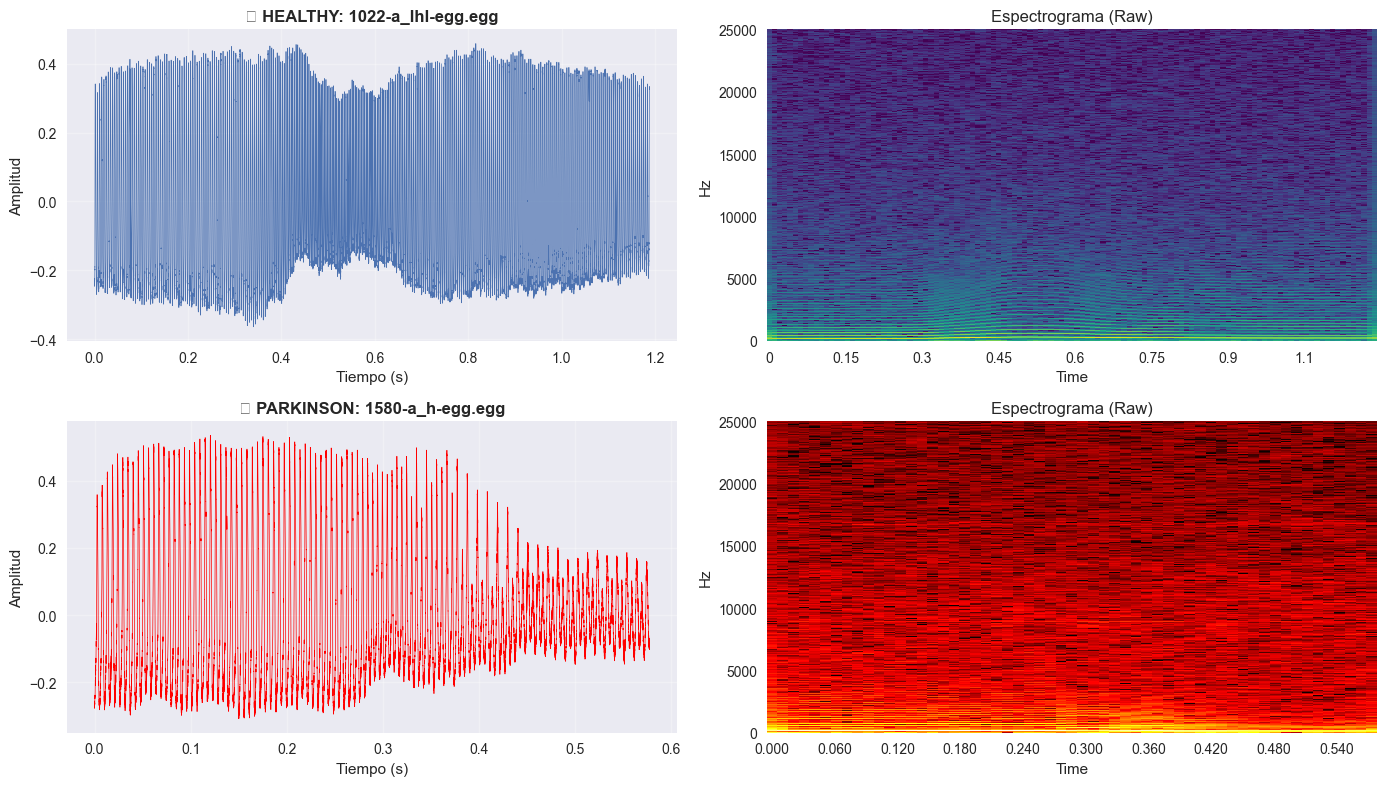

In [3]:
# ============================================================
# VISUALIZAR AUDIO ORIGINAL (SIN PROCESAMIENTO)
# ============================================================

print("="*70)
print("🔊 VISUALIZACIÓN DE AUDIO RAW")
print("="*70)

# Seleccionar un ejemplo de cada clase
example_healthy = audio_files_healthy[0] if audio_files_healthy else None
example_parkinson = audio_files_parkinson[0] if audio_files_parkinson else None

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Visualizar Healthy
if example_healthy:
    y_hc, sr_hc = librosa.load(example_healthy, sr=None)
    
    # Waveform
    axes[0, 0].plot(np.arange(len(y_hc)) / sr_hc, y_hc, linewidth=0.5)
    axes[0, 0].set_title(f"🟢 HEALTHY: {example_healthy.name}", fontweight='bold')
    axes[0, 0].set_xlabel("Tiempo (s)")
    axes[0, 0].set_ylabel("Amplitud")
    axes[0, 0].grid(alpha=0.3)
    
    # Espectrograma
    D_hc = librosa.amplitude_to_db(np.abs(librosa.stft(y_hc)), ref=np.max)
    librosa.display.specshow(D_hc, sr=sr_hc, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='viridis')
    axes[0, 1].set_title("Espectrograma (Raw)")
    
    print(f"🟢 Healthy: {example_healthy.name}")
    print(f"   • Duración: {len(y_hc)/sr_hc:.2f}s")
    print(f"   • Sample rate: {sr_hc} Hz")
    print(f"   • Samples: {len(y_hc):,}")

# Visualizar Parkinson
if example_parkinson:
    y_pd, sr_pd = librosa.load(example_parkinson, sr=None)
    
    # Waveform
    axes[1, 0].plot(np.arange(len(y_pd)) / sr_pd, y_pd, linewidth=0.5, color='red')
    axes[1, 0].set_title(f"🔴 PARKINSON: {example_parkinson.name}", fontweight='bold')
    axes[1, 0].set_xlabel("Tiempo (s)")
    axes[1, 0].set_ylabel("Amplitud")
    axes[1, 0].grid(alpha=0.3)
    
    # Espectrograma
    D_pd = librosa.amplitude_to_db(np.abs(librosa.stft(y_pd)), ref=np.max)
    librosa.display.specshow(D_pd, sr=sr_pd, x_axis='time', y_axis='hz', ax=axes[1, 1], cmap='hot')
    axes[1, 1].set_title("Espectrograma (Raw)")
    
    print(f"\n🔴 Parkinson: {example_parkinson.name}")
    print(f"   • Duración: {len(y_pd)/sr_pd:.2f}s")
    print(f"   • Sample rate: {sr_pd} Hz")
    print(f"   • Samples: {len(y_pd):,}")

plt.tight_layout()
plt.show()

print("="*70)


## 4. Preprocesamiento Básico

Procesar algunos archivos para ver el pipeline de preprocesamiento.


In [4]:
# ============================================================
# PROCESAMIENTO BASE (Sin Augmentation)
# ============================================================

print("="*70)
print("🔄 PREPROCESAMIENTO BÁSICO")
print("="*70)
print(f"\n📋 Pipeline:")
print(f"   1. Resampling a {SAMPLE_RATE} Hz")
print(f"   2. Segmentación en ventanas de {WINDOW_MS}ms con {OVERLAP*100:.0f}% overlap")
print(f"   3. Mel spectrogram ({N_MELS} bandas, hop {HOP_MS}ms)")
print(f"   4. Normalización z-score")
print(f"   5. Target shape: {N_MELS}×{TARGET_FRAMES}")

# Procesar Healthy (muestra pequeña para visualización)
print(f"\n🟢 Procesando HEALTHY (primeros 3 archivos)...")
results_healthy = build_full_pipeline(
    audio_files=audio_files_healthy[:3],
    preprocess_fn=None,
    max_files=None
)

dataset_healthy = results_healthy["dataset"]
(X_healthy_preview, y_task_healthy_preview, y_domain_healthy_preview) = results_healthy["tensors"]

print(f"   ✅ Healthy procesado:")
print(f"      • Archivos: 3")
print(f"      • Segmentos generados: {len(dataset_healthy)}")
print(f"      • Shape: {X_healthy_preview.shape}")

# Procesar Parkinson (muestra pequeña)
print(f"\n🔴 Procesando PARKINSON (primeros 3 archivos)...")
results_parkinson = build_full_pipeline(
    audio_files=audio_files_parkinson[:3],
    preprocess_fn=None,
    max_files=None
)

dataset_parkinson = results_parkinson["dataset"]
(X_parkinson_preview, y_task_parkinson_preview, y_domain_parkinson_preview) = results_parkinson["tensors"]

print(f"   ✅ Parkinson procesado:")
print(f"      • Archivos: 3")
print(f"      • Segmentos generados: {len(dataset_parkinson)}")
print(f"      • Shape: {X_parkinson_preview.shape}")

print("="*70)


🔄 PREPROCESAMIENTO BÁSICO

📋 Pipeline:
   1. Resampling a 44100 Hz
   2. Segmentación en ventanas de 400ms con 50% overlap
   3. Mel spectrogram (65 bandas, hop 10ms)
   4. Normalización z-score
   5. Target shape: 65×41

🟢 Procesando HEALTHY (primeros 3 archivos)...
🔄 Procesando 3 archivos...
  1/3: 1022-a_lhl-egg.egg
✅ 12 muestras generadas
📊 PyTorch tensors listos:
  - X: (12, 1, 65, 41)
  - y_task: (12,)  (dist={0: 12})
  - y_domain: (12,)  (K dominios=3)

📊 DISTRIBUCIÓN POR VOCAL:
  - a_lhl: 4 muestras
  - u_n: 2 muestras
  - u_h: 6 muestras

📊 DISTRIBUCIÓN POR CONDICIÓN:
  - egg: 12 muestras

✅ Dataset COMPLETO listo para entrenamiento con PyTorch!
  - Muestras totales: 12
  - Dimensiones de entrada: (12, 1, 65, 41)
  - Ideal para CNN 2D
   ✅ Healthy procesado:
      • Archivos: 3
      • Segmentos generados: 12
      • Shape: torch.Size([12, 1, 65, 41])

🔴 Procesando PARKINSON (primeros 3 archivos)...
🔄 Procesando 3 archivos...
  1/3: 1580-a_h-egg.egg
✅ 6 muestras generadas
📊 Py

## 5. Visualización de Espectrogramas Procesados

Ver cómo se ven los Mel spectrograms después del preprocesamiento.


📊 VISUALIZACIÓN DE MEL SPECTROGRAMS

🟢 Visualizando muestras de HEALTHY:


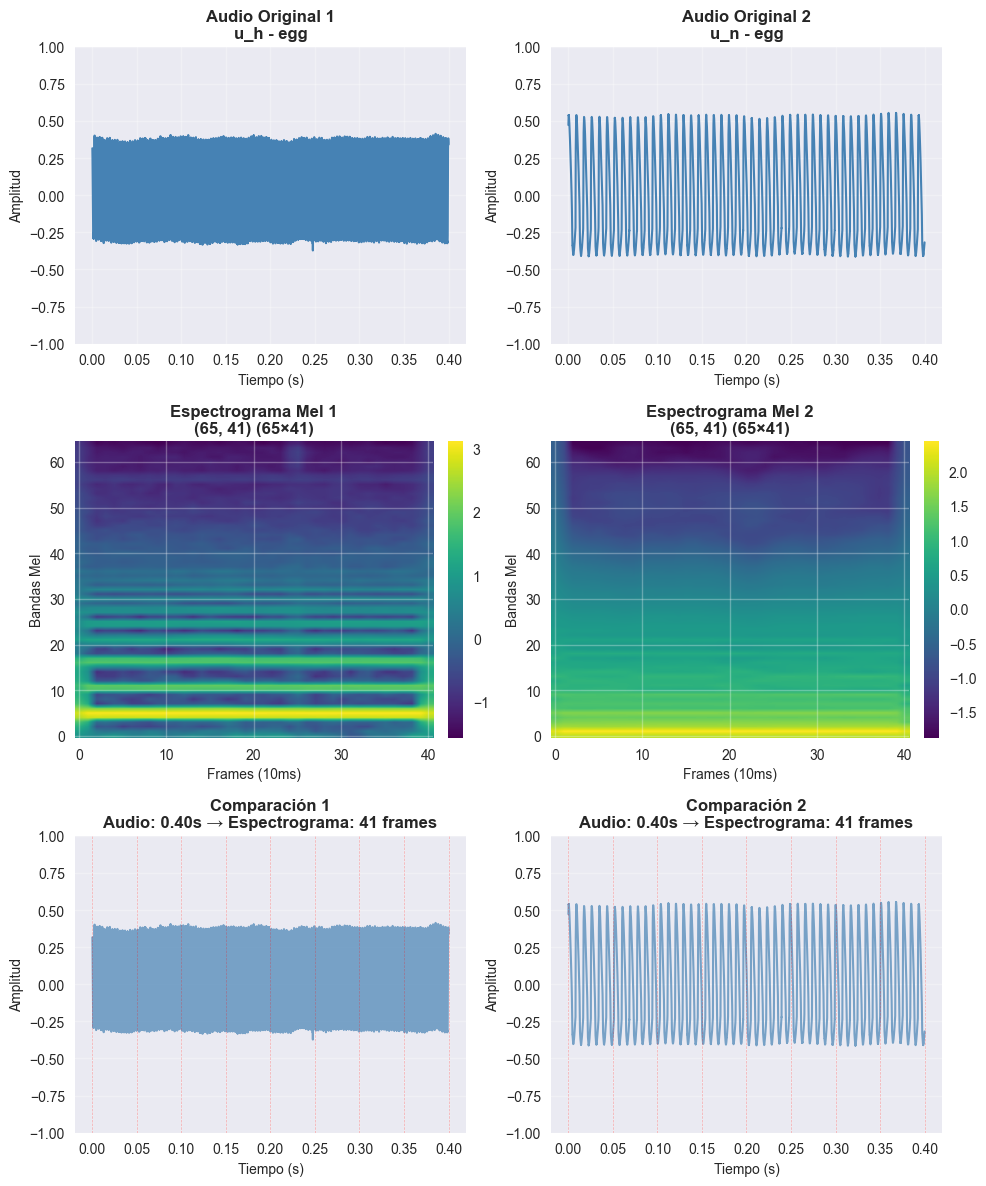


📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal u_n
  - Normalización: z-score aplicada
✅ Visualización Healthy completada

🔴 Visualizando muestras de PARKINSON:


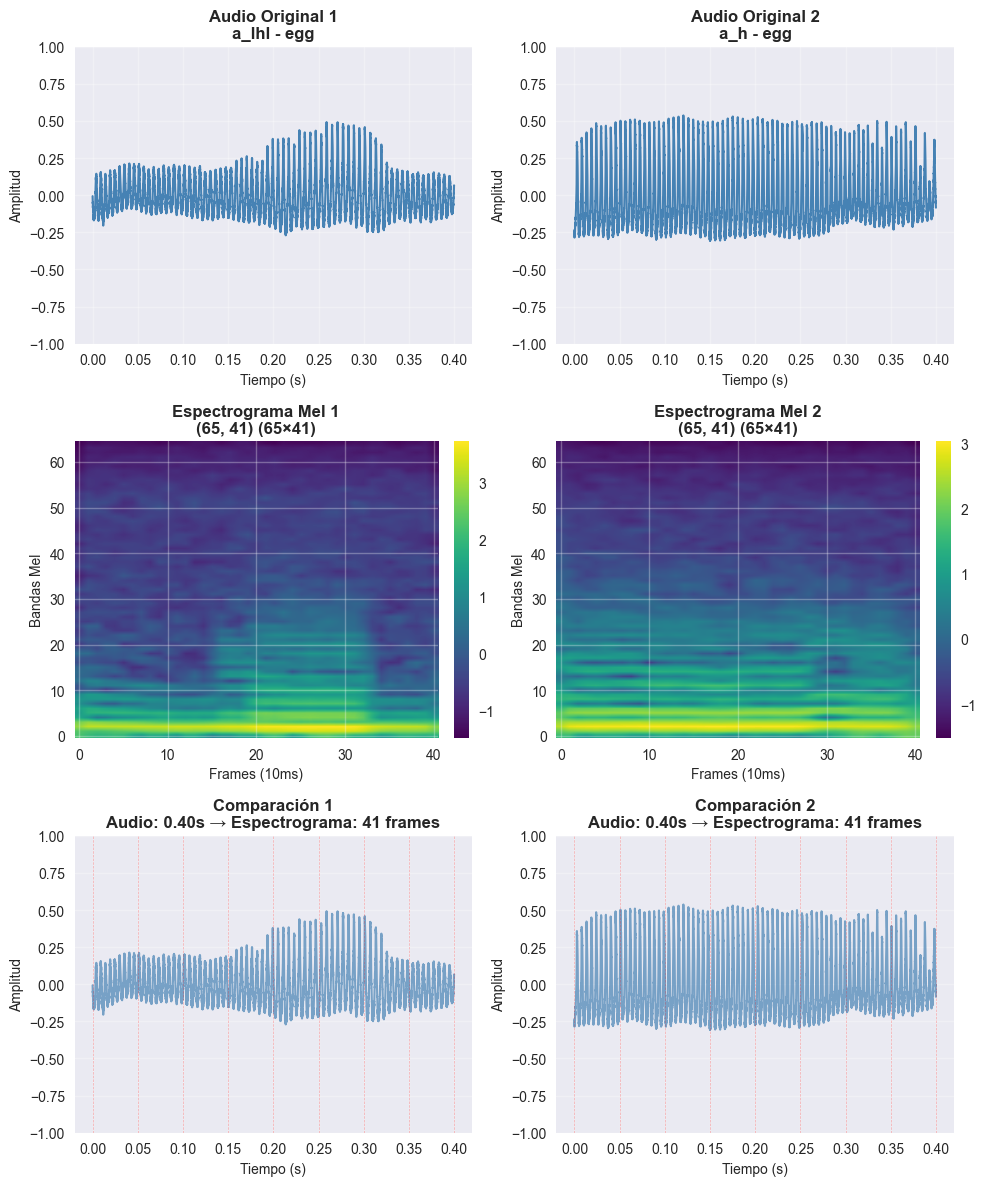


📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal a_h
  - Normalización: z-score aplicada
✅ Visualización Parkinson completada

💡 Observa las diferencias en patrones entre Healthy y Parkinson


In [5]:
# ============================================================
# VISUALIZAR ESPECTROGRAMAS PROCESADOS
# ============================================================

print("="*70)
print("📊 VISUALIZACIÓN DE MEL SPECTROGRAMS")
print("="*70)

# Visualizar muestras de Healthy
if dataset_healthy and len(dataset_healthy) > 0:
    print("\n🟢 Visualizando muestras de HEALTHY:")
    fig_healthy, audios_healthy = visualize_audio_and_spectrograms(
        dataset_healthy,
        num_samples=2,
        sr=SAMPLE_RATE,
        show=True,
        play_audio=False
    )
    print("✅ Visualización Healthy completada")

# Visualizar muestras de Parkinson
if dataset_parkinson and len(dataset_parkinson) > 0:
    print("\n🔴 Visualizando muestras de PARKINSON:")
    fig_parkinson, audios_parkinson = visualize_audio_and_spectrograms(
        dataset_parkinson,
        num_samples=2,
        sr=SAMPLE_RATE,
        show=True,
        play_audio=False
    )
    print("✅ Visualización Parkinson completada")

print("\n" + "="*70)
print("💡 Observa las diferencias en patrones entre Healthy y Parkinson")
print("="*70)


## 6. Data Augmentation - Ejemplos Visuales

Demostración de las técnicas de augmentation aplicadas.


🎨 DATA AUGMENTATION - TÉCNICAS

🎯 Archivo ejemplo: 1580-a_h-egg.egg
   • Subject: 1580
   • Vocal: a_h
   • Condición: egg

🔄 Aplicando augmentations...
   ✓ Original: 1 segmentos → 'original'
   ✓ Pitch +2: 1 segmentos → 'pitch_+2'
   ✓ Time 1.1x: 1 segmentos → 'time_1.10x'
   ✓ Ruido: 1 segmentos → 'noise_0.0050'


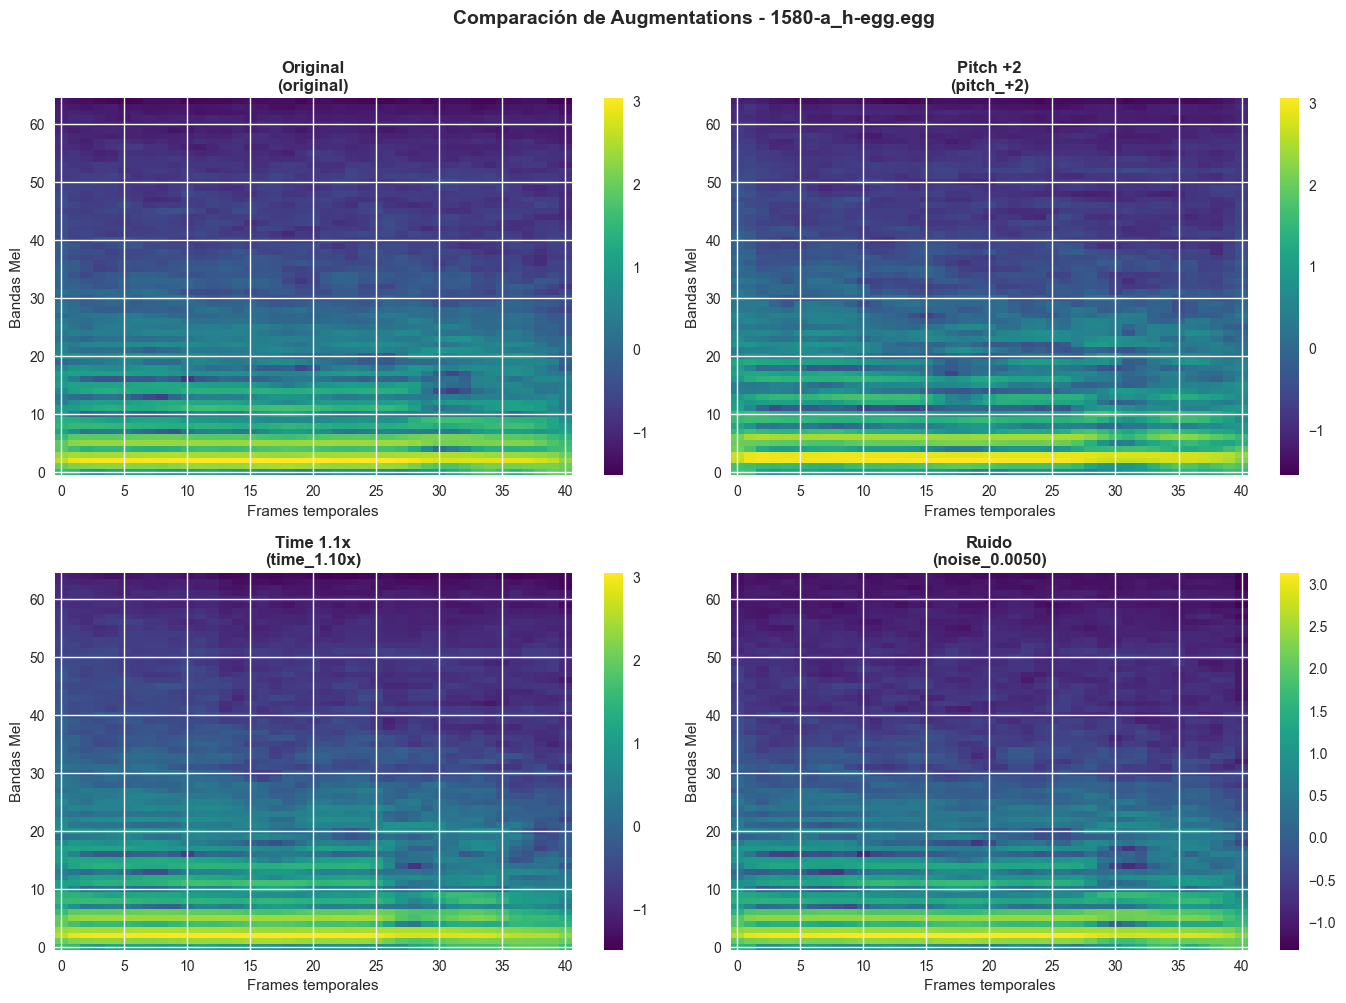


💡 Observa cómo cada técnica modifica el espectrograma


In [6]:
# ============================================================
# DEMOSTRACIÓN DE DATA AUGMENTATION
# ============================================================

print("="*70)
print("🎨 DATA AUGMENTATION - TÉCNICAS")
print("="*70)

# Usar un archivo de ejemplo
example_file = audio_files_parkinson[0] if audio_files_parkinson else None

if example_file:
    subject_id, vowel_type, condition = parse_filename(example_file.stem)
    print(f"\n🎯 Archivo ejemplo: {example_file.name}")
    print(f"   • Subject: {subject_id}")
    print(f"   • Vocal: {vowel_type}")
    print(f"   • Condición: {condition}")
    
    # Configuración de augmentations a demostrar
    aug_configs = {
        "Original": ("original", None),
        "Pitch +2": ("pitch_shift", {"n_steps": 2}),
        "Time 1.1x": ("time_stretch", {"rate": 1.1}),
        "Ruido": ("noise", {"noise_factor": 0.005})
    }
    
    results_aug = {}
    
    print(f"\n🔄 Aplicando augmentations...")
    for name, (aug_type, aug_params) in aug_configs.items():
        specs, segs, label = preprocess_audio_with_augmentation(
            example_file,
            vowel_type=vowel_type,
            aug_type=aug_type,
            aug_params=aug_params,
            apply_spec_augment=False
        )
        results_aug[name] = (specs[0] if specs else None, label)
        print(f"   ✓ {name}: {len(segs)} segmentos → '{label}'")
    
    # Visualizar comparación
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (name, (spec, label)) in enumerate(results_aug.items()):
        if spec is not None:
            im = axes[idx].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
            axes[idx].set_title(f"{name}\n({label})", fontweight='bold')
            axes[idx].set_xlabel('Frames temporales')
            axes[idx].set_ylabel('Bandas Mel')
            plt.colorbar(im, ax=axes[idx])
    
    plt.suptitle(f"Comparación de Augmentations - {example_file.name}", fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Observa cómo cada técnica modifica el espectrograma")
else:
    print("⚠️ No hay archivos para demostrar augmentation")

print("="*70)


## 7. SpecAugment - Máscaras de Frecuencia y Tiempo

Demostración de SpecAugment aplicado sobre espectrogramas.


✨ SPECAUGMENT - Máscaras de Frecuencia y Tiempo


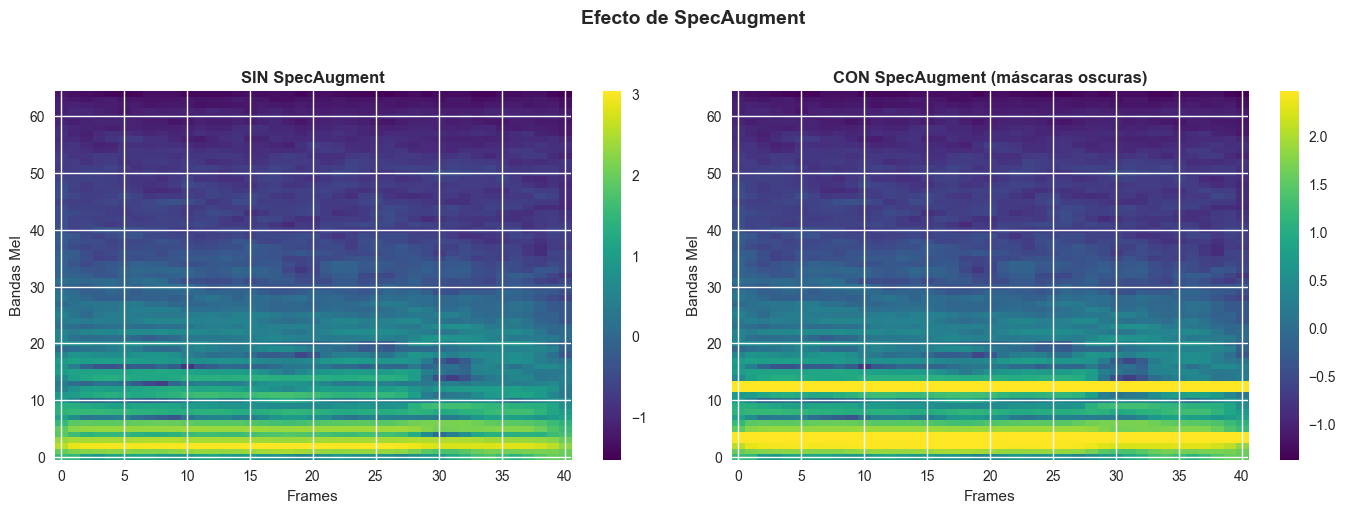

✅ SpecAugment visualizado
   💡 Las regiones oscuras son las máscaras aplicadas
   📊 Parámetros: freq_mask=10, time_mask=5


In [7]:
# ============================================================
# DEMOSTRACIÓN DE SPECAUGMENT
# ============================================================

print("="*70)
print("✨ SPECAUGMENT - Máscaras de Frecuencia y Tiempo")
print("="*70)

SPEC_AUG_PARAMS = {
    "freq_mask_param": 10,
    "time_mask_param": 5,
    "num_freq_masks": 2,
    "num_time_masks": 2
}

if example_file:
    # Sin SpecAugment
    specs_no_sa, _, _ = preprocess_audio_with_augmentation(
        example_file,
        vowel_type=vowel_type,
        aug_type="original",
        aug_params=None,
        apply_spec_augment=False
    )
    
    # Con SpecAugment
    specs_with_sa, _, _ = preprocess_audio_with_augmentation(
        example_file,
        vowel_type=vowel_type,
        aug_type="original",
        aug_params=None,
        apply_spec_augment=True,
        spec_augment_params=SPEC_AUG_PARAMS
    )
    
    # Visualizar comparación
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sin SpecAugment
    if specs_no_sa:
        im0 = axes[0].imshow(specs_no_sa[0], aspect='auto', origin='lower', cmap='viridis')
        axes[0].set_title("SIN SpecAugment", fontweight='bold', fontsize=12)
        axes[0].set_xlabel('Frames')
        axes[0].set_ylabel('Bandas Mel')
        plt.colorbar(im0, ax=axes[0])
    
    # Con SpecAugment
    if specs_with_sa:
        im1 = axes[1].imshow(specs_with_sa[0], aspect='auto', origin='lower', cmap='viridis')
        axes[1].set_title("CON SpecAugment (máscaras oscuras)", fontweight='bold', fontsize=12)
        axes[1].set_xlabel('Frames')
        axes[1].set_ylabel('Bandas Mel')
        plt.colorbar(im1, ax=axes[1])
    
    plt.suptitle("Efecto de SpecAugment", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ SpecAugment visualizado")
    print(f"   💡 Las regiones oscuras son las máscaras aplicadas")
    print(f"   📊 Parámetros: freq_mask={SPEC_AUG_PARAMS['freq_mask_param']}, time_mask={SPEC_AUG_PARAMS['time_mask_param']}")
else:
    print("⚠️ No hay archivos para demostrar SpecAugment")

print("="*70)


## 8. Generación Completa de Datos con Augmentation

Procesar TODOS los archivos y aplicar augmentation completa.


In [8]:
# ============================================================
# CONFIGURACIÓN DE AUGMENTATION COMPLETA
# ============================================================

print("="*70)
print("🎨 CONFIGURACIÓN DE AUGMENTATION COMPLETA")
print("="*70)

# Configuración
AUGMENTATION_TYPES = ["original", "pitch_shift", "time_stretch", "noise"]
NUM_SPEC_AUGMENT_VERSIONS = 2
USE_CACHE = True
FORCE_REGENERATE = False

CACHE_DIR_HEALTHY = "./cache/healthy"
CACHE_DIR_PARKINSON = "./cache/parkinson"

print(f"\n⚙️  Configuración:")
print(f"   • Técnicas de audio: {', '.join(AUGMENTATION_TYPES)}")
print(f"   • SpecAugment versions: {NUM_SPEC_AUGMENT_VERSIONS}")
print(f"   • Use cache: {USE_CACHE}")
print(f"   • Force regenerate: {FORCE_REGENERATE}")
print(f"\n💾 Directorios de cache:")
print(f"   • Healthy: {CACHE_DIR_HEALTHY}")
print(f"   • Parkinson: {CACHE_DIR_PARKINSON}")
print("="*70)


🎨 CONFIGURACIÓN DE AUGMENTATION COMPLETA

⚙️  Configuración:
   • Técnicas de audio: original, pitch_shift, time_stretch, noise
   • SpecAugment versions: 2
   • Use cache: True
   • Force regenerate: False

💾 Directorios de cache:
   • Healthy: ./cache/healthy
   • Parkinson: ./cache/parkinson


In [9]:
# ============================================================
# GENERAR DATOS AUGMENTADOS - HEALTHY
# ============================================================

print("\n" + "="*70)
print("🟢 GENERANDO DATOS AUGMENTADOS - HEALTHY")
print("="*70)

augmented_dataset_healthy = create_augmented_dataset(
    audio_files_healthy,
    augmentation_types=AUGMENTATION_TYPES,
    apply_spec_augment=True,
    num_spec_augment_versions=NUM_SPEC_AUGMENT_VERSIONS,
    use_cache=USE_CACHE,
    cache_dir=CACHE_DIR_HEALTHY,
    force_regenerate=FORCE_REGENERATE,
    progress_every=3
)

X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(augmented_dataset_healthy)

print(f"\n✅ HEALTHY COMPLETADO:")
print(f"   • Archivos originales: {len(audio_files_healthy)}")
print(f"   • Muestras augmentadas: {len(augmented_dataset_healthy)}")
print(f"   • Factor de multiplicación: {len(augmented_dataset_healthy)/len(audio_files_healthy):.1f}x")
print(f"   • Shape final: {X_healthy.shape}")
print("="*70)



🟢 GENERANDO DATOS AUGMENTADOS - HEALTHY
💾 Cargando dataset desde cache...
   📁 ./cache/healthy\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1553 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1553, 1, 65, 41)
  - y_task: (1553,)  (dist={0: 1553})
  - y_domain: (1553,)  (K dominios=13)

✅ HEALTHY COMPLETADO:
   • Archivos originales: 13
   • Muestras augmentadas: 1553
   • Factor de multiplicación: 119.5x
   • Shape final: torch.Size([1553, 1, 65, 41])


In [10]:
# ============================================================
# GENERAR DATOS AUGMENTADOS - PARKINSON
# ============================================================

print("\n" + "="*70)
print("🔴 GENERANDO DATOS AUGMENTADOS - PARKINSON")
print("="*70)

augmented_dataset_parkinson = create_augmented_dataset(
    audio_files_parkinson,
    augmentation_types=AUGMENTATION_TYPES,
    apply_spec_augment=True,
    num_spec_augment_versions=NUM_SPEC_AUGMENT_VERSIONS,
    use_cache=USE_CACHE,
    cache_dir=CACHE_DIR_PARKINSON,
    force_regenerate=FORCE_REGENERATE,
    progress_every=3
)

X_parkinson, y_task_parkinson, y_domain_parkinson, meta_parkinson = to_pytorch_tensors(augmented_dataset_parkinson)

print(f"\n✅ PARKINSON COMPLETADO:")
print(f"   • Archivos originales: {len(audio_files_parkinson)}")
print(f"   • Muestras augmentadas: {len(augmented_dataset_parkinson)}")
print(f"   • Factor de multiplicación: {len(augmented_dataset_parkinson)/len(audio_files_parkinson):.1f}x")
print(f"   • Shape final: {X_parkinson.shape}")
print("="*70)



🔴 GENERANDO DATOS AUGMENTADOS - PARKINSON
🎨 Creando dataset con augmentation...
   Archivos: 13 | Tipos: ['original', 'pitch_shift']...
   ✨ SpecAugment: ACTIVADO
  1/13: 1580-a_h-egg.egg
  4/13: 1580-a_n-egg.egg
  7/13: 1580-i_l-egg.egg
  10/13: 1580-u_h-egg.egg
  13/13: 1580-u_n-egg.egg

✅ Dataset: 1219 muestras totales
💾 Guardando dataset en cache...
   📁 ./cache/parkinson\augmented_dataset_c6631e32.pkl
✅ Cache guardado: 103.9 MB
💡 Próxima ejecución será instantánea!
📊 PyTorch tensors listos:
  - X: (1219, 1, 65, 41)
  - y_task: (1219,)  (dist={0: 1219})
  - y_domain: (1219,)  (K dominios=13)

✅ PARKINSON COMPLETADO:
   • Archivos originales: 13
   • Muestras augmentadas: 1219
   • Factor de multiplicación: 93.8x
   • Shape final: torch.Size([1219, 1, 65, 41])


## 9. Resumen y Verificación del Cache

Verificar que los datos se guardaron correctamente en cache.


In [11]:
# ============================================================
# RESUMEN FINAL Y VERIFICACIÓN
# ============================================================

print("\n" + "="*70)
print("📊 RESUMEN DE PREPROCESAMIENTO")
print("="*70)

print(f"\n🎯 DATOS GENERADOS:")
print(f"   🟢 Healthy:   {X_healthy.shape[0]:4d} espectrogramas | Shape: {tuple(X_healthy.shape[1:])}")
print(f"   🔴 Parkinson: {X_parkinson.shape[0]:4d} espectrogramas | Shape: {tuple(X_parkinson.shape[1:])}")
print(f"   📊 Total:     {X_healthy.shape[0] + X_parkinson.shape[0]:4d} espectrogramas")

balance_pct = X_parkinson.shape[0] / (X_healthy.shape[0] + X_parkinson.shape[0]) * 100
print(f"\n📈 BALANCE:")
print(f"   • Parkinson: {balance_pct:.1f}%")
print(f"   • Healthy: {100-balance_pct:.1f}%")

# Verificar cache
import os
cache_files = []

for cache_dir, name in [(CACHE_DIR_HEALTHY, "Healthy"), (CACHE_DIR_PARKINSON, "Parkinson")]:
    cache_path = Path(cache_dir)
    if cache_path.exists():
        pkl_files = list(cache_path.glob("*.pkl"))
        if pkl_files:
            cache_files.extend(pkl_files)
            print(f"\n✅ Cache {name}:")
            for f in pkl_files:
                size_mb = os.path.getsize(f) / (1024 * 1024)
                print(f"   • {f.name} ({size_mb:.1f} MB)")

if cache_files:
    total_size = sum(os.path.getsize(f) for f in cache_files) / (1024 * 1024)
    print(f"\n💾 CACHE TOTAL: {total_size:.1f} MB")
    print(f"   ⚡ Ahorro de tiempo en próximas ejecuciones: ~6 minutos")

print("\n" + "="*70)
print("✅ PREPROCESAMIENTO COMPLETADO")
print("="*70)
print(f"\n🚀 PRÓXIMOS PASOS:")
print(f"   1. Entrenar CNN2D baseline → cnn_training.ipynb")
print(f"   2. Entrenar CNN2D_DA → cnn_da_training.ipynb")
print(f"   3. Comparar resultados entre ambos modelos")
print("\n💡 Los datos ya están en cache, los entrenamientos serán rápidos!")
print("="*70)



📊 RESUMEN DE PREPROCESAMIENTO

🎯 DATOS GENERADOS:
   🟢 Healthy:   1553 espectrogramas | Shape: (1, 65, 41)
   🔴 Parkinson: 1219 espectrogramas | Shape: (1, 65, 41)
   📊 Total:     2772 espectrogramas

📈 BALANCE:
   • Parkinson: 44.0%
   • Healthy: 56.0%

✅ Cache Healthy:
   • augmented_dataset_c6631e32.pkl (132.5 MB)

✅ Cache Parkinson:
   • augmented_dataset_c6631e32.pkl (103.9 MB)

💾 CACHE TOTAL: 236.4 MB
   ⚡ Ahorro de tiempo en próximas ejecuciones: ~6 minutos

✅ PREPROCESAMIENTO COMPLETADO

🚀 PRÓXIMOS PASOS:
   1. Entrenar CNN2D baseline → cnn_training.ipynb
   2. Entrenar CNN2D_DA → cnn_da_training.ipynb
   3. Comparar resultados entre ambos modelos

💡 Los datos ya están en cache, los entrenamientos serán rápidos!
